# Multilevel text summarization

In [2]:
# general imports
import warnings
import nltk
import pandas as pd
import numpy as np
import scipy as sp
from time import time, sleep
import json
import requests
import random
import os
import matplotlib.pyplot as plt
import re
from sklearn.externals import joblib
# Clean and lemmatize text
from nltk.corpus import stopwords
from gensim.utils import smart_open, simple_preprocess
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import sent_tokenize, word_tokenize

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning)

random.seed(0)
%matplotlib inline

In [2]:
pp_dir = '/Users/dbm/Downloads/OPP-115/sanitized_policies/'
oo_dir = '/Users/dbm/Downloads/OptOutChoice-2017_v1.0/SanitizedPrivacyPolicies/'

In [3]:
# Read in all story files
def ls_fullpath(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory)]

In [10]:
def extract_co_name(file, pat='\d+_|\.com|\.edu|\.html'):
    co_name = re.sub(pattern=pat, repl='', string=os.path.basename(file))
    return co_name

In [25]:
extract_co_name(oo_files[1])

'store.steampowered'

In [151]:
pp_files = ls_fullpath(directory=pp_dir)
oo_files = ls_fullpath(directory=oo_dir)
oo_files = [i for i in oo_files if '.DS_Store' not in i]
# print(oo_files)
co_names_pp = [extract_co_name(file=file) for file in pp_files]
co_names_oo = [extract_co_name(file=file) for file in oo_files]
co_names = co_names_pp + co_names_oo
co_names

['latinpost',
 'google',
 'austincc',
 'pbs.org',
 'usa.gov',
 'geocaching',
 'uh',
 'timeinc',
 'dcccd',
 'ted',
 'ticketmaster',
 'stlouisfed.org',
 'coffeereview',
 'dogbreedinfo',
 'earthkam.org',
 'zacks',
 'sheknows',
 'opensecrets.org',
 'highgearmedia',
 'bankofamerica',
 'liquor',
 'msn',
 'reference',
 'neworleansonline',
 'military',
 'buffalowildwings',
 'randomhouse',
 'redorbit',
 'lodgemfg',
 'voxmedia',
 'si',
 'citizen.org',
 'yahoo',
 'everydayhealth',
 'internetbrands',
 'taylorswift',
 'foxsports',
 'aol',
 'gwdocs',
 'ocregister',
 'acbj',
 'naturalnews',
 'playstation',
 'dairyqueen',
 'solarviews',
 'mlb.mlb',
 'abita',
 'honda',
 'eatchicken',
 'cariboucoffee',
 'washingtonian',
 'dailynews',
 'miaminewtimes',
 'reddit',
 'nbcuniversal',
 'www.loc.gov',
 'fredericknewspost',
 'ifsa-butler.org',
 'wsmv',
 'rockstargames',
 'cincymuseum.org',
 'archives.gov',
 'dailyillini',
 'communitycoffee',
 'freep',
 'thefreedictionary',
 'sidearmsports',
 'gamestop',
 'chase

In [63]:
file

'/Users/dbm/Downloads/OPP-115/sanitized_policies/1713_latinpost.com.html'

In [8]:
# Get test text
from bs4 import BeautifulSoup
filt_len = 6
import requests


r  = requests.get('https://machinebox.io/privacy')

data = r.text
soup = BeautifulSoup(data, 'html.parser')
tmp = sent_tokenize(''.join(soup.findAll(text=True)))
tmp_sent = [re.sub('[^a-zA-z0-9.?! ]+', '', i).rstrip() for i in tmp]
tmp_sent = [
    re.sub(pattern='[ \t]{2,}', repl=' ', string=i) for i in tmp_sent
    if len(i) > filt_len
]
txt = ' '.join(tmp_sent)
type(pd.Series(txt))
# for link in soup.find_all('a'):
#     print(link.get('href'))

pandas.core.series.Series

In [324]:
import spacy

nlp = spacy.load('en_core_web_sm')
doc = nlp(txt)

# for ent in doc.ents:
#     print(ent.text, ent.start_char, ent.end_char, ent.label_)

# Get organization name from text
np.unique([ent.text for ent in doc.ents if ent.label_ == 'ORG'])

array(['Agreement', 'Amazon Web Services', 'Anton BoulevardCosta Mesa',
       'Box', 'ContactIf', 'ContactPoint', 'Customer', 'EEA', 'Licenses',
       'Machine', 'Machine Box', 'Machine Box Machine',
       'Machine Box Service', 'Machine Box Serviceto', 'Veritone Inc.',
       'the Information Commissioners Office', 'the Machine Box Service',
       'the Machine Box Services', 'toVeritone'], dtype='<U36')

In [106]:
doc_type = 'oo'
file = oo_files[2]
html_file = open(file, 'r')
source_code = html_file.read()
soup = BeautifulSoup(source_code, 'html.parser')
tmp = sent_tokenize(''.join(soup.findAll(text=True)))
tmp_sent = [re.sub('[^a-zA-z0-9.?! ]+', '', i).rstrip() for i in tmp]
tmp_sent = [
    re.sub(pattern='[ \t]{2,}', repl=' ', string=i) for i in tmp_sent
    if len(i) > filt_len
]
txt = ' '.join(tmp_sent)
# print(txt)
# Flatten list of lists
# txt = ' '.join([item for sublist in tmp_sent for item in sublist])
try:
    year = re.search(string=txt, pattern='20\d{2}').group()
except AttributeError:
    year = ''  # apply your error handling
    type(year)
data = {'file': file, 'year': year, 'doc_type': doc_type, 'text': txt}
data

{'file': '/Users/dbm/Downloads/OptOutChoice-2017_v1.0/SanitizedPrivacyPolicies/1708_yardbraker.com.html',
 'year': '2015',
 'doc_type': 'oo',
 'text': ' SEARCH Search VIEW FULL LIST Sign In Profile Email Settings Account Info Linking Sign Out FOXSPORTS FOX Sports Digital Privacy Policy Effective Date June 11 2015 1. Introduction Fox Sports Digital FSD which is operated and controlled by Fox Networks Group Inc. has developed this Privacy Policy to describe how we collect use and disclose information from and about you. This Privacy Policy describes our practices in connection with information collected through the sportsrelated websites the FSD Sites mobile sites applications apps widgets and other content and services that are linked to this Privacy Policy collectively the FSD Services including the following FSD Sites Foxsports.com Foxsoccer.com and SoonerSports.tv.By providing personal information to us and using the FSD Services you agree to the terms and conditions of this Privacy 

In [12]:
import html5lib
import re
from bs4 import BeautifulSoup
import requests

In [13]:
# tokenize, lower case, and lemmatize words
def tokenize(series, stop_words, frequent_words, org_names):
    return (
        series
        .apply(lambda x: simple_preprocess(x))
        .apply(lambda tokens: [token for token in tokens if token not in stop_words])
        .apply(lambda tokens: [token for token in tokens if token not in frequent_words])
        .apply(lambda tokens: [token for token in tokens if token not in org_names])
        #         .apply(lambda tokens: [token for token in tokens if token not in publishers])
        .apply(lambda tokens: [wnl.lemmatize(token) for token in tokens])
        .apply(lambda tokens: [token for token in tokens if len(token) > 3])
    )

In [123]:
def read_html(file, filt_len=6, doc_type='pp'):
    #     print(file)
    html_file = open(file, 'r', errors='ignore')
    source_code = html_file.read()
    soup = BeautifulSoup(source_code, 'html.parser')
    tmp = sent_tokenize(''.join(soup.findAll(text=True)))
    tmp_sent = [re.sub('[^a-zA-z0-9.?! ]+', '', i).rstrip() for i in tmp]
    tmp_sent = [
        re.sub(pattern='[ \t]{2,}', repl=' ', string=i) for i in tmp_sent
        if len(i) > filt_len
    ]
    txt = ' '.join(tmp_sent)
    # print(txt)
    # Flatten list of lists
    # txt = ' '.join([item for sublist in tmp_sent for item in sublist])
    try:
        year = re.search(string=txt, pattern='20\d{2}').group()
    except AttributeError:
        year = ''  # apply your error handling
        type(year)
    data = {'file': file, 'year': year, 'doc_type': doc_type, 'text': txt}
    return data

In [39]:
file = pp_files[0]
filt_len = 6

In [86]:
def strip_html(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

In [126]:
pp = [read_html(file=file, doc_type='pp') for file in pp_files]
oo = [read_html(file=file, doc_type='oo') for file in oo_files]

print(
    f'No. of Privacy policy Documents: {len(pp)} \nNo. of Opt out policy Documents: {len(oo)}'
)

No. of Privacy policy Documents: 115 
No. of Opt out policy Documents: 114


In [132]:
documents = pp + oo
df = pd.DataFrame(documents)
# df = pd.concat([pp, oo])
df.head(3)

,doc_type,file,text,year
0,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Privacy Policy Last Modified March 25 2013 Thi...,2013
1,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Welcome to the Google Privacy Policy When you...,2015
2,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Web Privacy Statement Austin Community Colleg...,


In [133]:
# Save data for future use
from pickle import dump, load
dump(df, open("/Users/dbm/Documents/Insight S19/data/privacy_optout_policy.pkl", "wb"))
# dump(df, open("/Users/dbm/Documents/Insight S19/data/opt_out_policy.pkl", "wb"))

In [184]:
# Words to filter
stop_words = set(stopwords.words('english'))
frequent_words = ['privacy', 'policy', 'andor', 'terms', 'service', 'please']
frequent_words.append(co_names)
wnl = WordNetLemmatizer()

In [185]:
%% time
# Clean, lemmatize, and tokenize text
data_words = tokenize(df['text'], stop_words=stop_words,
                      frequent_words=frequent_words)
data_words = [' '.join(word) for word in data_words]
print(f'type: {type(data_words)}, len: {len(data_words)}')

type: <class 'list'>, len: 229
CPU times: user 2.02 s, sys: 26.5 ms, total: 2.05 s
Wall time: 2.05 s


### Business name processing

In [373]:
from cleanco import cleanco

# print(co_names)
# x = cleanco(co_names[1])
# x.clean_name()
# print(x.type())

['latinpost', 'google', 'austincc', 'pbs.org', 'usa.gov', 'geocaching', 'uh', 'timeinc', 'dcccd', 'ted', 'ticketmaster', 'stlouisfed.org', 'coffeereview', 'dogbreedinfo', 'earthkam.org', 'zacks', 'sheknows', 'opensecrets.org', 'highgearmedia', 'bankofamerica', 'liquor', 'msn', 'reference', 'neworleansonline', 'military', 'buffalowildwings', 'randomhouse', 'redorbit', 'lodgemfg', 'voxmedia', 'si', 'citizen.org', 'yahoo', 'everydayhealth', 'internetbrands', 'taylorswift', 'foxsports', 'aol', 'gwdocs', 'ocregister', 'acbj', 'naturalnews', 'playstation', 'dairyqueen', 'solarviews', 'mlb.mlb', 'abita', 'honda', 'eatchicken', 'cariboucoffee', 'washingtonian', 'dailynews', 'miaminewtimes', 'reddit', 'nbcuniversal', 'www.loc.gov', 'fredericknewspost', 'ifsa-butler.org', 'wsmv', 'rockstargames', 'cincymuseum.org', 'archives.gov', 'dailyillini', 'communitycoffee', 'freep', 'thefreedictionary', 'sidearmsports', 'gamestop', 'chasepaymentech', 'disinfo', 'instagram', 'vikings', 'kraftrecipes', 'kal

In [186]:
# data = {}
# for co in co_names:
#     print(co)
#     try:
#         name = co.clean_name()
#         co_type = co.type()
#         country = co.country()
#     except:
#         name = ''
#         co_type = ''
#         country = ''

#     data = {'name': name,
#             'type': co_type,
#             'country': country}

# business_name = "statement farlex farlex privately owned corporation"
# x = cleanco(business_name)
# x.type()
# x.country()
# x.clean_name()
# data

In [187]:
data_words

['last modified march latinpost site intended explain practice cover following area applies governing safe harbor collection personal information information wireless marketing service associated promotional opportunity optingout certain personal information information wireless marketing service associated promotional opportunity wireless marketing service associated promotional opportunity sharing disclosure personal information information reviewing updating deleting certain information protection information california right change notice miscellaneous applies applies whether accessing site personal computer mobile device technology device known hereafter developed discovered device whether accessing site registered user offered site user site governs personal information information term defined collected site cover information collected manner parent company subsidiary affiliate parent company collectively affiliate collected company unless specifically stated time time combine i

## Topic modeling

### Create corpora for topic modeling

In [211]:
%% time
split_data_words = [sentence.split() for sentence in data_words]

# Create Dictionary
id2word = corpora.Dictionary(split_data_words)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in split_data_words]

# View
# print(corpus[:1])

CPU times: user 325 ms, sys: 10.7 ms, total: 335 ms
Wall time: 334 ms


In [212]:
id2word[0]

'able'

In [213]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [214]:
% % time
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=6,
                                            random_state=0,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

CPU times: user 14.1 s, sys: 78.5 ms, total: 14.2 s
Wall time: 3.57 s


In [215]:
# Print the Keyword in the 6 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.058*"information" + 0.030*"site" + 0.013*"website" + 0.011*"medianews" + '
  '0.011*"service" + 0.010*"identifiable" + 0.010*"party" + 0.010*"email" + '
  '0.010*"personally" + 0.009*"third"'),
 (1,
  '0.042*"information" + 0.029*"google" + 0.024*"example" + 0.021*"service" + '
  '0.015*"account" + 0.013*"learn" + 0.011*"yahoo" + 0.011*"microsoft" + '
  '0.009*"search" + 0.009*"personal"'),
 (2,
  '0.039*"service" + 0.020*"information" + 0.013*"content" + 0.010*"including" '
  '+ 0.009*"otherwise" + 0.009*"without" + 0.008*"agreement" + 0.008*"access" '
  '+ 0.007*"mobile" + 0.007*"right"'),
 (3,
  '0.063*"information" + 0.021*"service" + 0.015*"personal" + 0.012*"website" '
  '+ 0.011*"provide" + 0.009*"company" + 0.009*"online" + 0.008*"collect" + '
  '0.008*"share" + 0.008*"receive"'),
 (4,
  '0.055*"information" + 0.034*"service" + 0.018*"site" + 0.014*"user" + '
  '0.013*"personal" + 0.013*"email" + 0.013*"party" + 0.012*"third" + '
  '0.009*"provide" + 0.008*"collect"')

In [216]:
# Compute Perplexity
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=split_data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


ldatopics = lda_model.show_topics(formatted=False)


Perplexity:  -6.776660888476974

Coherence Score:  0.31992250757543844


In [217]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/envs/insight_s19/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.035589 -0.019982       1        1  37.227760
0     -0.009998 -0.011247       2        1  27.346542
3      0.024471 -0.050770       3        1  14.534612
2     -0.174150  0.105108       4        1   9.641882
1      0.013803 -0.136685       5        1   6.125832
5      0.181464  0.113576       6        1   5.123373, topic_info=     Category          Freq           Term         Total  loglift  logprob
364   Default  14825.000000    information  14825.000000  30.0000  30.0000
666   Default   6933.000000        service   6933.000000  29.0000  29.0000
920   Default    647.000000         google    647.000000  28.0000  28.0000
807   Default   2464.000000        website   2464.000000  27.0000  27.0000
269   Default   1082.000000        example   1082.000000  26.0000  26.0000
6     Default   1315.000000        account   1315.000000  25.0000  25.0000
3412  Default    856.000000      medianews    856.000000  24.0000  24.0000
393   Default    487.000000          learn    487.000000  23.0000  23.0000
171   Default   2055.000000          cooky   2055.000000  22.0000  22.0000
161   Default   1389.000000        content   1389.000000  21.0000  21.0000
512   Default   2894.000000       personal   2894.000000  20.0000  20.0000
2277  Default    256.000000          yahoo    256.000000  19.0000  19.0000
450   Default    836.000000         mobile    836.000000  18.0000  18.0000
355   Default   1413.000000      including   1413.000000  17.0000  17.0000
211   Default   1092.000000         device   1092.000000  16.0000  16.0000
4767  Default    193.000000     tulsaworld    193.000000  15.0000  15.0000
188   Default   1353.000000           data   1353.000000  14.0000  14.0000
1007  Default    362.000000         search    362.000000  13.0000  13.0000
4864  Default    179.000000           fool    179.000000  12.0000  12.0000
3     Default   1516.000000         access   1516.000000  11.0000  11.0000
40    Default    421.000000      agreement    421.000000  10.0000  10.0000
2253  Default    203.000000      microsoft    203.000000   9.0000   9.0000
493   Default    540.000000      otherwise    540.000000   8.0000   8.0000
814   Default    553.000000        without    553.000000   7.0000   7.0000
504   Default   2606.000000          party   2606.000000   6.0000   6.0000
127   Default   2051.000000        collect   2051.000000   5.0000   5.0000
402   Default    245.000000     limitation    245.000000   4.0000   4.0000
549   Default   1175.000000        product   1175.000000   3.0000   3.0000
677   Default   4803.000000           site   4803.000000   2.0000   2.0000
4880  Default    147.000000         motley    147.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
1891   Topic6     55.642075        science     84.807114   2.5499  -5.5843
733    Topic6     34.949615     television     48.416363   2.6454  -6.0494
4876   Topic6     21.326437        million     28.028793   2.6981  -6.5433
4970   Topic6     22.106987     restaurant     30.397247   2.6529  -6.5074
1058   Topic6     56.210819          world    137.173309   2.0792  -5.5742
807    Topic6    281.211426        website   2464.714600   0.8006  -3.9642
2176   Topic6     37.100483       merchant     93.145981   2.0508  -5.9896
1639   Topic6     28.861961        reading     59.101845   2.2546  -6.2408
364    Topic6    386.910645    information  14825.160156  -0.6745  -3.6451
2460   Topic6     29.050488          title     62.938324   2.1982  -6.2342
188    Topic6    105.757759           data   1353.603638   0.4220  -4.9421
2352   Topic6     34.130367  international     92.090714   1.9788  -6.0731
969    Topic6     49.277443         people    221.858643   1.4668  -5.7058
29     Topic6     74.019447     advertiser    610.216492   0.8619  -5.2990
101    Topic6     65.930290           card    470.466339   1.0062  -5.4147


In [218]:
vis2 = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='tsne')
vis2

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4       59.747993   52.410496       1        1  37.221302
0       50.658867 -557.580139       2        1  27.352169
3      248.404968 -286.025238       3        1  14.535543
2     -138.914673 -280.256348       4        1   9.641873
1      393.789856   16.783026       5        1   6.126433
5     -275.206146   26.753918       6        1   5.122674, topic_info=     Category          Freq           Term         Total  loglift  logprob
364   Default  14825.000000    information  14825.000000  30.0000  30.0000
666   Default   6932.000000        service   6932.000000  29.0000  29.0000
920   Default    647.000000         google    647.000000  28.0000  28.0000
807   Default   2464.000000        website   2464.000000  27.0000  27.0000
269   Default   1082.000000        example   1082.000000  26.0000  26.0000
6     Default   1315.000000        account   1315.000000  25.0000  25.0000
3412  Default    856.000000      medianews    856.000000  24.0000  24.0000
393   Default    487.000000          learn    487.000000  23.0000  23.0000
171   Default   2055.000000          cooky   2055.000000  22.0000  22.0000
161   Default   1389.000000        content   1389.000000  21.0000  21.0000
512   Default   2894.000000       personal   2894.000000  20.0000  20.0000
2277  Default    256.000000          yahoo    256.000000  19.0000  19.0000
450   Default    836.000000         mobile    836.000000  18.0000  18.0000
355   Default   1413.000000      including   1413.000000  17.0000  17.0000
211   Default   1092.000000         device   1092.000000  16.0000  16.0000
4767  Default    193.000000     tulsaworld    193.000000  15.0000  15.0000
188   Default   1353.000000           data   1353.000000  14.0000  14.0000
1007  Default    362.000000         search    362.000000  13.0000  13.0000
4864  Default    179.000000           fool    179.000000  12.0000  12.0000
3     Default   1516.000000         access   1516.000000  11.0000  11.0000
40    Default    421.000000      agreement    421.000000  10.0000  10.0000
2253  Default    203.000000      microsoft    203.000000   9.0000   9.0000
493   Default    540.000000      otherwise    540.000000   8.0000   8.0000
814   Default    553.000000        without    553.000000   7.0000   7.0000
504   Default   2606.000000          party   2606.000000   6.0000   6.0000
127   Default   2051.000000        collect   2051.000000   5.0000   5.0000
402   Default    245.000000     limitation    245.000000   4.0000   4.0000
549   Default   1175.000000        product   1175.000000   3.0000   3.0000
677   Default   4803.000000           site   4803.000000   2.0000   2.0000
4880  Default    147.000000         motley    147.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
1891   Topic6     55.634495        science     84.805420   2.5499  -5.5843
733    Topic6     34.944855     television     48.409641   2.6456  -6.0494
4876   Topic6     21.323532        million     28.027147   2.6981  -6.5433
4970   Topic6     22.103975     restaurant     30.395756   2.6529  -6.5074
1058   Topic6     56.203163          world    137.173126   2.0792  -5.5742
807    Topic6    281.173126        website   2464.841797   0.8006  -3.9642
2176   Topic6     37.095428       merchant     93.148300   2.0508  -5.9896
1639   Topic6     28.858030        reading     59.094963   2.2547  -6.2408
364    Topic6    386.857941    information  14825.259766  -0.6745  -3.6451
2460   Topic6     29.046532          title     62.935379   2.1983  -6.2342
188    Topic6    105.743355           data   1353.584961   0.4220  -4.9421
2352   Topic6     34.125721  international     92.084076   1.9788  -6.0731
969    Topic6     49.270733         people    221.864456   1.4668  -5.7058
29     Topic6     74.009369     advertiser    610.175415   0.8619  -5.2990
101    Topic6     65.921310           card 

## LSI (ranked topics)

In [238]:
lsimodel = LsiModel(corpus=corpus, num_topics=6, id2word=id2word)

In [239]:
lsimodel.show_topics(num_topics=6)  # Showing only the top 5 topics

[(0,
  '0.683*"information" + 0.378*"service" + 0.226*"site" + 0.144*"personal" + 0.128*"party" + 0.119*"third" + 0.118*"email" + 0.112*"user" + 0.110*"provide" + 0.105*"website"'),
 (1,
  '0.705*"service" + -0.296*"information" + -0.253*"site" + 0.197*"content" + 0.137*"agreement" + 0.131*"including" + 0.130*"otherwise" + 0.122*"available" + 0.110*"limitation" + -0.109*"personal"'),
 (2,
  '0.654*"site" + 0.423*"medianews" + -0.231*"website" + -0.186*"information" + -0.182*"barnes" + -0.182*"noble" + 0.130*"user" + -0.119*"personal" + 0.105*"group" + 0.089*"health"'),
 (3,
  '0.607*"microsoft" + 0.318*"account" + 0.270*"search" + 0.266*"bing" + -0.202*"health" + 0.130*"site" + 0.130*"cooky" + -0.105*"website" + 0.103*"advertising" + -0.092*"information"'),
 (4,
  '0.745*"health" + 0.273*"kaleida" + -0.211*"medianews" + -0.130*"barnes" + -0.130*"noble" + -0.122*"third" + 0.122*"everyday" + -0.120*"party" + 0.119*"microsoft" + 0.112*"information"'),
 (5,
  '-0.461*"barnes" + -0.461*"nob

In [263]:
lsitopics = lsimodel.show_topics(formatted=False)

In [258]:
# lsitopics

## HDP model

In [242]:
hdpmodel = HdpModel(corpus=corpus, id2word=id2word, random_state = 0)

In [259]:
# hdpmodel.show_topics()

In [262]:
hdptopics = hdpmodel.show_topics(formatted=False)
# hdptopics

### Method comparison

In [264]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

print(len(lsitopics), len(hdptopics))
# ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

# lmtopics = [[word for word, prob in topic] for topicid, topic in lmtopics]

6 20


In [265]:
lsi_coherence = CoherenceModel(
    topics=lsitopics, texts=split_data_words, dictionary=id2word, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(
    topics=hdptopics[:10], texts=split_data_words, dictionary=id2word, window_size=10).get_coherence()

print(f'lsi: {lsi_coherence}, hdp: {hdp_coherence}')

lsi: 0.30313273307854555, hdp: 0.18945333706493775


## LDA mallet

In [164]:
mallet_path = '/Users/dbm/Downloads/mallet-2.0.8/bin/mallet'  # update this path
ldamallet = gensim.models.wrappers.LdaMallet(
    mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [166]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(
    model=ldamallet, texts=split_data_words, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('information', 0.0816793893129771),
   ('personal', 0.047285835453774384),
   ('website', 0.027014418999151822),
   ('customer', 0.019423240033927057),
   ('email', 0.01789652247667515),
   ('product', 0.01726039016115352),
   ('provide', 0.012425784563189143),
   ('collect', 0.012128922815945718),
   ('card', 0.012086513994910942),
   ('contact', 0.012086513994910942)]),
 (10,
  [('information', 0.05005693680015183),
   ('site', 0.03838489276902638),
   ('service', 0.03212184475232492),
   ('user', 0.030271398747390398),
   ('email', 0.023249193395331182),
   ('party', 0.01802998671474663),
   ('message', 0.016654014044410703),
   ('marketing', 0.014186752704498007),
   ('address', 0.013332700702220535),
   ('personal', 0.012953122034541659)]),
 (12,
  [('information', 0.07332695984703633),
   ('address', 0.022848948374760994),
   ('request', 0.02265774378585086),
   ('provide', 0.021510516252390057),
   ('credit', 0.019980879541108987),
   ('email', 0.018738049713193115),
 

In [167]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(
            mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [169]:
% % time
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word, corpus=corpus, texts=split_data_words, start=3, limit=10, step=1)

CPU times: user 12.1 s, sys: 670 ms, total: 12.8 s
Wall time: 5min 2s


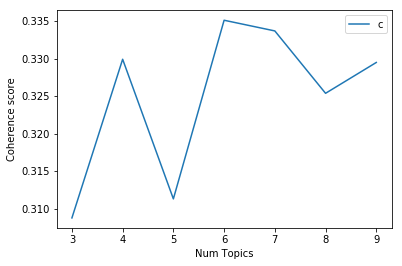

In [170]:
# Show graph
limit = 10
start = 3
step = 1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [171]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.3088
Num Topics = 4  has Coherence Value of 0.3299
Num Topics = 5  has Coherence Value of 0.3113
Num Topics = 6  has Coherence Value of 0.3351
Num Topics = 7  has Coherence Value of 0.3337
Num Topics = 8  has Coherence Value of 0.3254
Num Topics = 9  has Coherence Value of 0.3295


In [174]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.052*"information" + 0.020*"website" + 0.018*"health" + 0.012*"visitor" + '
  '0.012*"site" + 0.010*"research" + 0.010*"personal" + 0.008*"public" + '
  '0.007*"contact" + 0.006*"collect"'),
 (1,
  '0.060*"service" + 0.025*"andor" + 0.021*"information" + 0.021*"content" + '
  '0.014*"including" + 0.013*"access" + 0.011*"agreement" + 0.010*"party" + '
  '0.009*"user" + 0.009*"term"'),
 (2,
  '0.072*"information" + 0.059*"service" + 0.018*"personal" + 0.017*"collect" '
  '+ 0.014*"online" + 0.013*"party" + 0.012*"advertising" + 0.011*"website" + '
  '0.011*"device" + 0.011*"email"'),
 (3,
  '0.069*"information" + 0.020*"personal" + 0.016*"account" + 0.015*"provide" '
  '+ 0.013*"site" + 0.013*"email" + 0.013*"address" + 0.012*"customer" + '
  '0.010*"product" + 0.010*"credit"'),
 (4,
  '0.092*"site" + 0.058*"information" + 0.022*"email" + 0.017*"address" + '
  '0.015*"personal" + 0.014*"party" + 0.014*"user" + 0.013*"medianews" + '
  '0.011*"time" + 0.010*"collected"'),
 (5,
  '

In [337]:
optimal_model.show_topics(formatted=True, num_topics=16, num_words=10)

[(0,
  '0.052*"information" + 0.020*"website" + 0.018*"health" + 0.012*"visitor" + 0.012*"site" + 0.010*"research" + 0.010*"personal" + 0.008*"public" + 0.007*"contact" + 0.006*"collect"'),
 (1,
  '0.060*"service" + 0.025*"andor" + 0.021*"information" + 0.021*"content" + 0.014*"including" + 0.013*"access" + 0.011*"agreement" + 0.010*"party" + 0.009*"user" + 0.009*"term"'),
 (2,
  '0.072*"information" + 0.059*"service" + 0.018*"personal" + 0.017*"collect" + 0.014*"online" + 0.013*"party" + 0.012*"advertising" + 0.011*"website" + 0.011*"device" + 0.011*"email"'),
 (3,
  '0.069*"information" + 0.020*"personal" + 0.016*"account" + 0.015*"provide" + 0.013*"site" + 0.013*"email" + 0.013*"address" + 0.012*"customer" + 0.010*"product" + 0.010*"credit"'),
 (4,
  '0.092*"site" + 0.058*"information" + 0.022*"email" + 0.017*"address" + 0.015*"personal" + 0.014*"party" + 0.014*"user" + 0.013*"medianews" + 0.011*"time" + 0.010*"collected"'),
 (5,
  '0.073*"information" + 0.032*"website" + 0.026*"ide

In [176]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=split_data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series(
                    [int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic',
                              'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(
    ldamodel=optimal_model, corpus=corpus, texts=split_data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [177]:
df_dominant_topic.head(2)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.6281,"site, information, email, address, personal, p...","[last, modified, march, latinpost, site, inten..."
1,1,2.0,0.3932,"information, service, personal, collect, onlin...","[welcome, service, trust, information, meant, ..."


In [349]:
# from gensim.models.wrappers import LdaMallet
# mallet2lda = LdaMallet(optimal_model, id2word = id2word, num_topics = 6)
# # mallet2lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
# # data = pyLDAvis.gensim.prepare(mallet2lda, corpus, id2word)
# # pyLDAvis.display(data)
# mallet2lda

import gensim    
mallet_2_lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [351]:
# vis3 = pyLDAvis.gensim.prepare(mallet_2_lda, corpus = corpus, dictionary = id2word)
# vis3

## NMF

In [290]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, TfidfModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import pickle
import scipy as sp
import sklearn
import sys


In [272]:
# Count design matrix
# The transformation will return a matrix of size (Documents x Features), 
# where the value of a cell is going to be the number of times the feature (word) appears in that document
vectorizer = CountVectorizer(analyzer='word', lowercase=False)
x_counts = vectorizer.fit_transform(data_words)

In [273]:
# TfIdf Transformer: transform the counts with the model
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [274]:
# Normalize the TfIdf values to unit length for each row
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [293]:
#obtain a NMF model
num_topics = 6
nmf_model = NMF(n_components=num_topics, init='nndsvd');
#fit the model
nmf_model.fit(xtfidf_norm)

# nmf_model = gensim.models.nmf.Nmf(corpus = corpus, num_topics=6, id2word=id2word, random_state = 0, normalize = True)
#fit the model
# nmf_model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
  max_iter=200, n_components=6, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [280]:
def get_nmf_topics(model, n_top_words, num_topics):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [281]:
get_nmf_topics(nmf_model, n_top_words = 20, num_topics = 6)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06
0,information,geekdo,medianews,tanger,breed,valve
1,service,information,information,outlet,info,steam
2,site,valueclick,site,tangeroutlets,center,user
3,website,boardgamegeek,group,greensboro,adsense,information
4,personal,explicit,yahoo,distributed,google,personally
5,party,valueclickmedia,careerbuilder,keeping,photo,identifiable
6,email,service,coordinator,utilize,serve,game
7,third,investigate,denver,simply,dbic,product
8,collect,register,interactive,removal,information,service
9,cooky,shtml,colfax,attn,enjoyment,corporation


In [354]:
print(f'NMF reconstruction error: {nmf_model.reconstruction_err_}')

NMF reconstruction error: 1.3887629905724637


In [294]:
# Compute Perplexity
# a measure of how good the model is. lower the better.
# print('\nPerplexity: ', nmf_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_nmf = CoherenceModel(
    model=nmf_model, texts=corpus, dictionary=id2word, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print('\nCoherence Score: ', coherence_nmf)



ValueError: This topic model is not currently supported. Supported topic models should implement the `get_topics` method.

In [ ]:
ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]


## Word2Vec

In [295]:
import spacy

# nlp = spacy.load('en_core_web_sm')
# doc = nlp(df['text'][0])

# for ent in doc.ents:
#     print(ent.text, ent.start_char, ent.end_char, ent.label_)
# len(split_data_words)

In [188]:
model = gensim.models.Word2Vec(split_data_words, min_count=1, workers=10)
model.train(documents, total_examples=len(split_data_words), epochs=20)

(13740, 18320)

In [207]:
w1 = "jibjab"
model.wv.most_similar(positive=w1)

[('covered', 0.9380477070808411),
 ('inability', 0.9157547354698181),
 ('smithsonians', 0.915569543838501),
 ('vising', 0.9129244089126587),
 ('originating', 0.90545654296875),
 ('reflects', 0.9010685682296753),
 ('aspect', 0.8961746692657471),
 ('external', 0.892967939376831),
 ('accessible', 0.8850280046463013),
 ('widget', 0.884796679019928)]

In [196]:
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
# print(words)
# access vector for one word
# print(model['sentence'])
# save model
model.save('pp_oo_w2v_model.bin')
# load model
new_model = gensim.models.Word2Vec.load('pp_oo_w2v_model.bin')
print(new_model)

Word2Vec(vocab=8069, size=100, alpha=0.025)
Word2Vec(vocab=8069, size=100, alpha=0.025)


In [201]:
gensim.models.Word2Vec(max_vocab_size=14, size=100, alpha=0.25)

In [205]:
# Retrieve all the vectors from a trained model
X = model[model.wv.vocab]
X

array([[-0.00373342, -0.17521562, -0.26326072, ..., -0.5132973 ,
         0.28812063, -0.9119386 ],
       [-0.02219855, -0.11775608, -0.18203041, ..., -0.23244171,
         0.07718182, -0.36907807],
       [ 0.04162635, -0.03223521, -0.2062268 , ..., -0.12278496,
         0.11347291, -0.17559682],
       ...,
       [ 0.00636408, -0.00233499, -0.03853553, ..., -0.00819143,
         0.01649433, -0.00232303],
       [ 0.00513343, -0.00314208, -0.04204533, ..., -0.01881775,
         0.02331555, -0.01528585],
       [ 0.00707369, -0.00684318, -0.04209677, ..., -0.0090302 ,
         0.0152616 , -0.01069375]], dtype=float32)

In [209]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '/Users/dbm/Documents/Insight S19/data/glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [210]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)
# calculate: (king - man) + woman = ?
# result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
# print(result)

## doc2vec

In [306]:
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
import collections
import smart_open
import random
# !nltk.download('punkt')

In [297]:
documents = [TaggedDocument(doc, [i])
             for i, doc in enumerate(split_data_words)]
documents[0]

TaggedDocument(words=['last', 'modified', 'march', 'latinpost', 'site', 'intended', 'explain', 'practice', 'cover', 'following', 'area', 'applies', 'governing', 'safe', 'harbor', 'collection', 'personal', 'information', 'information', 'wireless', 'marketing', 'service', 'associated', 'promotional', 'opportunity', 'optingout', 'certain', 'personal', 'information', 'information', 'wireless', 'marketing', 'service', 'associated', 'promotional', 'opportunity', 'wireless', 'marketing', 'service', 'associated', 'promotional', 'opportunity', 'sharing', 'disclosure', 'personal', 'information', 'information', 'reviewing', 'updating', 'deleting', 'certain', 'information', 'protection', 'information', 'california', 'right', 'change', 'notice', 'miscellaneous', 'applies', 'applies', 'whether', 'accessing', 'site', 'personal', 'computer', 'mobile', 'device', 'technology', 'device', 'known', 'hereafter', 'developed', 'discovered', 'device', 'whether', 'accessing', 'site', 'registered', 'user', 'offe

In [303]:
doc2vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [304]:
# Build a vocab
doc2vec_model.build_vocab(documents)

In [305]:
%%time 
# Train model
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

CPU times: user 14.8 s, sys: 186 ms, total: 15 s
Wall time: 5.8 s


### Assessing model quality

In [309]:
ranks = []
second_ranks = []
for doc_id in range(len(documents)):
    inferred_vector = doc2vec_model.infer_vector(documents[doc_id].words)
    sims = doc2vec_model.docvecs.most_similar([inferred_vector], topn=len(doc2vec_model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    
    second_ranks.append(sims[1])

In [357]:
# Count how each document ranks with respect to the training corpus
collections.Counter(ranks)  # Results vary between runs due to random seeding and very small corpus

Counter({0: 185, 1: 43, 3: 1})

In [358]:
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(documents[doc_id].words)))
print(f'SIMILAR/DISSIMILAR DOCS PER MODEL :\n {doc2vec_model}')
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(documents[sims[index][0]].words)))

Document (228): «friday policywe want make online mobile experience satisfying safe want provide mean control give voice question concern digital mobile application certain information activity collected information determine user preference design initiative meet preference eliminate hassle generally make friday experience satisfying time time initiate program service survey request name birthday email address city residence code information like like friday recognize loyalty customer depends upon relationship strongly support right customer maintain personal data dont worry friday personal information safe logging mobile application mobile application asked whether want mobile application remember choose mobile application remain logged information time choose choosing logout button application commitment family like child concerned safety internet want family safe visiting website consistent federal childrens online protection coppa offer program participation minor never knowingly 

## Summarize

In [312]:
from gensim.summarization.summarizer import summarize

In [330]:
text = summarize(txt, ratio = .05)
text

'This privacy policy together with our Terms of Service and Cookies Policy sets out the basis on which any personal data we collect from you or that you provide to us whether directly or by authorized access will be processed by us.\nStorage of your informationWe will store your personal data only for as long as necessary so that we can update and provide the Machine Box Service to you.\nDisclosure of your informationWe may disclose your personal information to selected third parties including our agents business partners suppliers service providers such as Amazon Web Services and affiliates to assist us with providing the Machine Box Services developing and operating our systems and applications processing payments customer support and communications.'

## References
- https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html#topic=0&lambda=1&term=
- https://radimrehurek.com/gensim/models/lsimodel.html
- https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb